<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/Assignment6/Homework6_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import datetime

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/My Drive/DataSets/'
cifar10 = datasets.CIFAR10(data_path,train=True,download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform = transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(cifar10)

50000

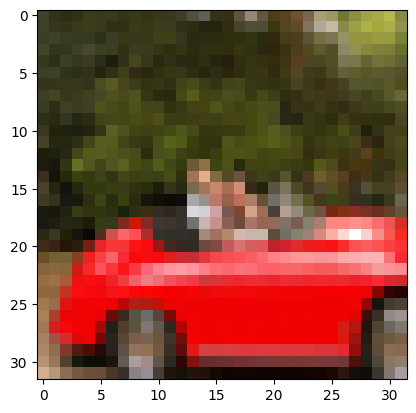

In [5]:
img_t, _ = cifar10[99]
img_t.shape
plt.imshow(img_t.permute(1,2,0))

In [6]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [7]:
imgs.view(3,-1).mean(dim=1)
imgs.view(3,-1).std(dim=1)


tensor([0.2470, 0.2435, 0.2616])

In [8]:
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [9]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

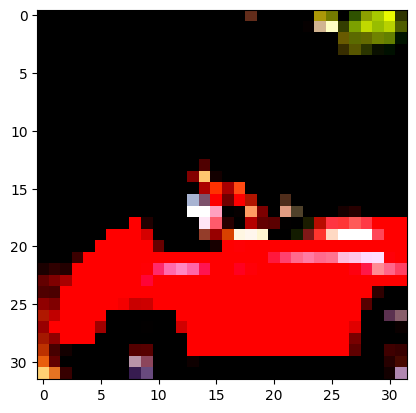

In [10]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [11]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 824),
                      nn.Tanh(),
                      nn.Linear(824, 204),
                      nn.Tanh(),
                      nn.Linear(204, 10),
                      nn.LogSoftmax(dim=1))



In [12]:
loss = nn.NLLLoss()
img, label = transformed_cifar10[99]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(2.2878, grad_fn=<NllLossBackward0>)

In [13]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size = 64, shuffle=True)

loss_fn = nn.NLLLoss()
n_epochs = 300
losses = []
start = datetime.datetime.now()
for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
  losses.append(loss.item())

end = datetime.datetime.now()

Epoch: 0, Loss: 1.661129
Epoch: 1, Loss: 1.988890
Epoch: 2, Loss: 1.479197
Epoch: 3, Loss: 1.869405
Epoch: 4, Loss: 1.350256
Epoch: 5, Loss: 1.136164
Epoch: 6, Loss: 1.421659
Epoch: 7, Loss: 1.751682
Epoch: 8, Loss: 1.256218
Epoch: 9, Loss: 1.967656
Epoch: 10, Loss: 1.191949
Epoch: 11, Loss: 0.727974
Epoch: 12, Loss: 1.110419
Epoch: 13, Loss: 1.192120
Epoch: 14, Loss: 0.854877
Epoch: 15, Loss: 1.434896
Epoch: 16, Loss: 1.376773
Epoch: 17, Loss: 1.084371
Epoch: 18, Loss: 1.278557
Epoch: 19, Loss: 1.371165
Epoch: 20, Loss: 0.466708
Epoch: 21, Loss: 0.808133
Epoch: 22, Loss: 0.457570
Epoch: 23, Loss: 0.601291
Epoch: 24, Loss: 0.551340
Epoch: 25, Loss: 0.922112
Epoch: 26, Loss: 0.700343
Epoch: 27, Loss: 0.236352
Epoch: 28, Loss: 0.288860
Epoch: 29, Loss: 0.222116
Epoch: 30, Loss: 0.326405
Epoch: 31, Loss: 0.469678
Epoch: 32, Loss: 0.183828
Epoch: 33, Loss: 0.347001
Epoch: 34, Loss: 0.246069
Epoch: 35, Loss: 0.357171
Epoch: 36, Loss: 0.242106
Epoch: 37, Loss: 0.338278
Epoch: 38, Loss: 0.455

In [17]:
time = end-start
print(str(time))

2:12:14.854910


In [15]:
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
  shuffle=False)
correct = 0
total = 0
val_losses = []
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        val_losses.append(loss.item())
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)


Accuracy: %f 0.4558


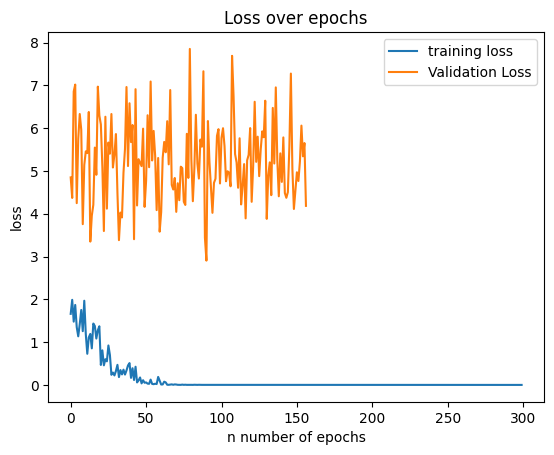

In [16]:
# 4. Plot the training and validation loss after each iteration
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()